In [ ]:
!git clone https://github.com/xuebinqin/U-2-Net.git
%cd U-2-Net

!pip install -r requirements.txt

!mkdir saved_models
!gdown --id 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O saved_models/u2netp.pth

Cloning into 'U-2-Net'...
remote: Enumerating objects: 1077, done.
remote: Counting objects: 100% (422/422), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1077 (delta 398), reused 380 (delta 380), pack-reused 655 (from 2)
Receiving objects: 100% (1077/1077), 66.95 MiB | 35.54 MiB/s, done.
Resolving deltas: 100% (536/536), done.
/content/U-2-Net
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 42.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 MB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of opencv-python to determine which version is compatible with other

In [ ]:
from PIL import Image
import os
from torchvision import transforms
import torch
import numpy as np
import cv2

from model.u2net import U2NETP

net = U2NETP(3, 1)
net.load_state_dict(torch.load('saved_models/u2netp.pth', map_location='cpu'))
net.eval()


def preprocess_image(path):
    image = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0), image


def predict_mask(image_tensor):
    with torch.no_grad():
        d1, *_ = net(image_tensor)
        pred = d1[:, 0, :, :]
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        return pred.squeeze().cpu().numpy()


def apply_mask_with_alpha(original, mask):
    mask_resized = cv2.resize(mask, original.size)
    mask_normalized = (mask_resized * 255).astype(np.uint8)

    original_np = np.array(original)


    if original_np.shape[2] == 3:
        rgba = np.dstack((original_np, mask_normalized))
    else:
        rgba = original_np.copy()
        rgba[..., 3] = mask_normalized

    return Image.fromarray(rgba, 'RGBA')


tensor, original = preprocess_image("/content/person.jpg")
mask = predict_mask(tensor)
result = apply_mask_with_alpha(original, mask)
result.save("person_cutout.png")

print("Segmentation complete. Saved as: person_cutout.png")


/content/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


✅ Segmentation complete. Saved as: person_cutout.png


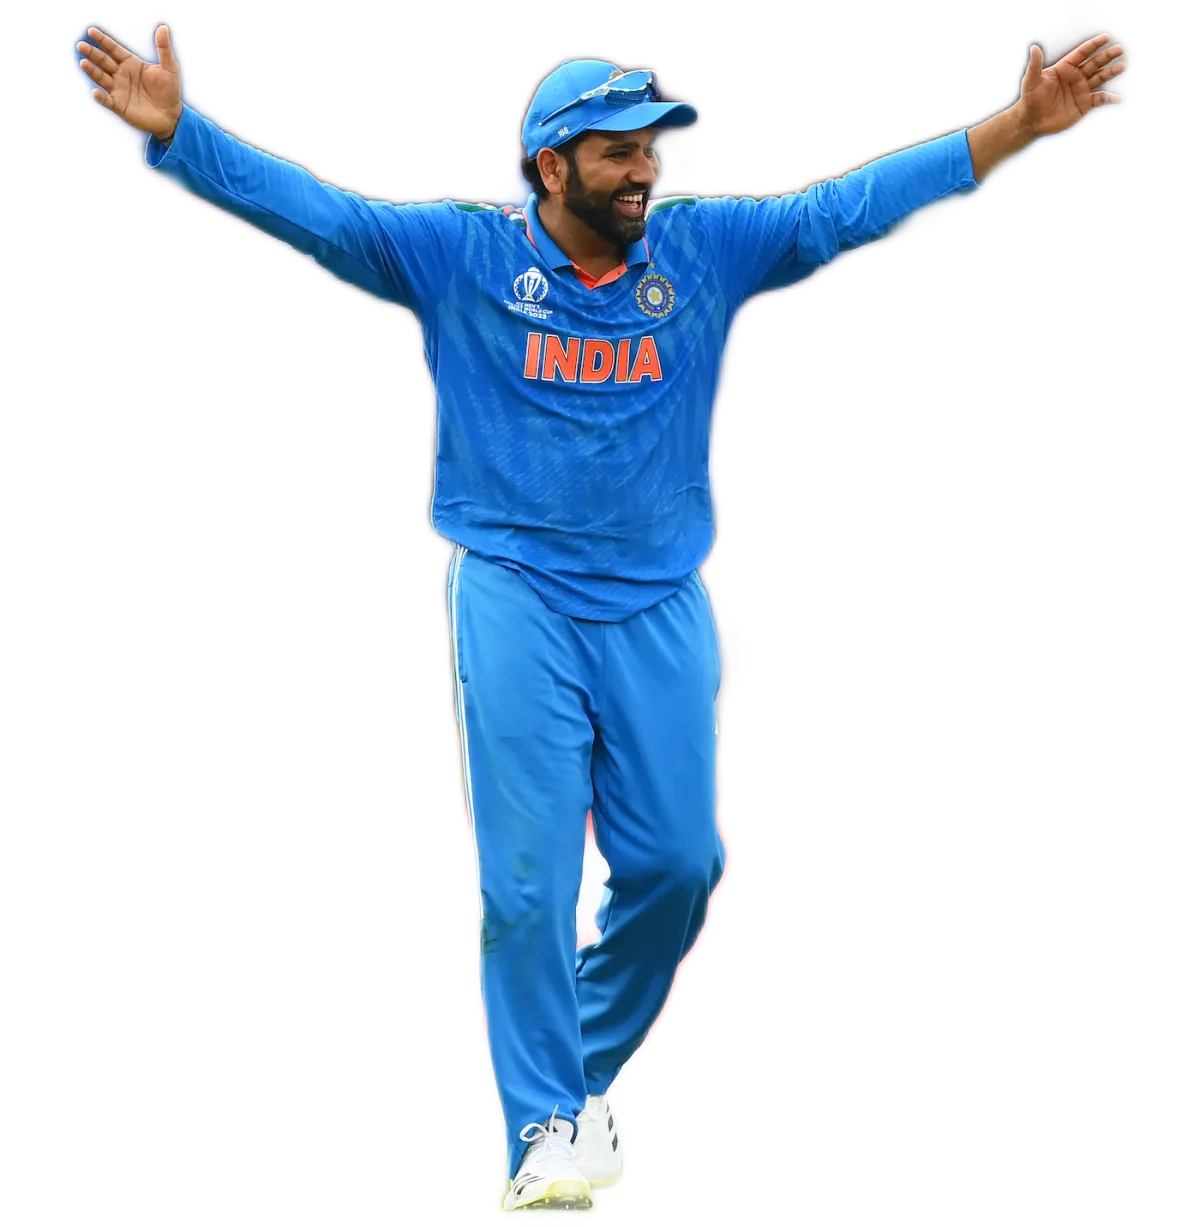

In [ ]:
from IPython.display import Image as ColabImage
from IPython.display import display


display(ColabImage(filename='person_cutout.png'))


In [ ]:
!cp person_cutout.png /content/


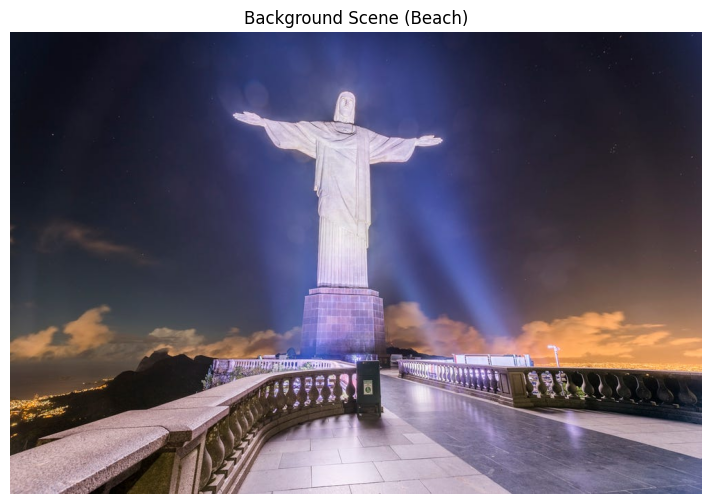

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

scene = Image.open("/content/scene.jpg")
plt.figure(figsize=(10,6))
plt.imshow(scene)
plt.axis('off')
plt.title("Background Scene (Beach)")
plt.show()


In [ ]:
from PIL import Image


bg = Image.open("/content/scene.jpg").convert("RGBA")
person = Image.open("person_cutout.png").convert("RGBA")

scale_factor = 0.2
new_width = int(person.width * scale_factor)
new_height = int(person.height * scale_factor)
person = person.resize((new_width, new_height), Image.Resampling.LANCZOS)


position = (620,375)


composite = bg.copy()
composite.paste(person, position, person)
composite.save("composite_no_shadow.png")


composite.show()


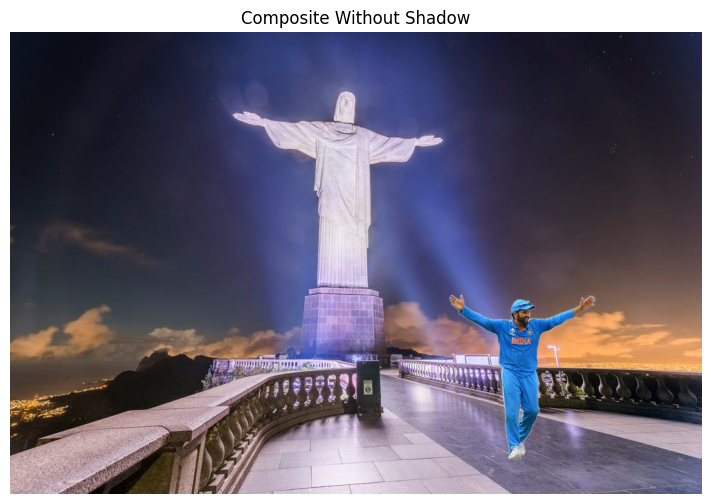

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("composite_no_shadow.png")
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Composite Without Shadow")
plt.show()


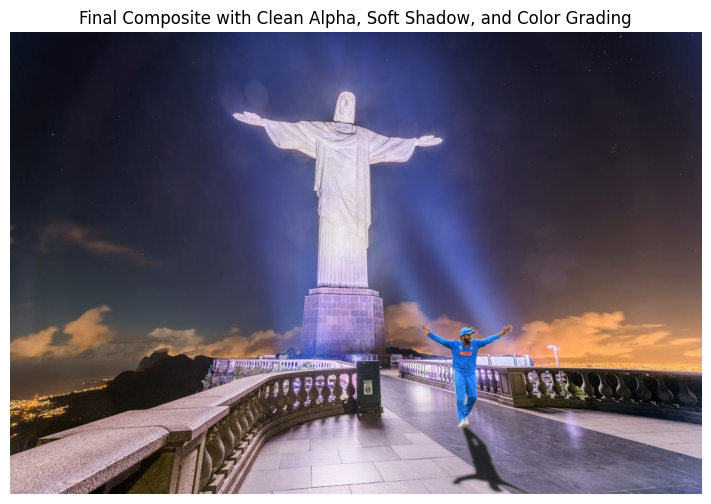

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt


bg = Image.open("/content/scene.jpg").convert("RGBA")
person = Image.open("person_cutout.png").convert("RGBA")


scale_factor = 0.125
person = person.resize(
    (int(person.width * scale_factor), int(person.height * scale_factor)),
    Image.Resampling.LANCZOS
)
position = (585, 420)


def color_grade(image):
    img_np = np.array(image).astype(np.float32)


    img_np[..., 0] *= 0.96  # Red
    img_np[..., 2] *= 1.05  # Blue

    # magenta tint
    img_np[..., 0] *= 1.02
    img_np[..., 1] *= 0.97
    img_np[..., 2] *= 1.01


    img_np = np.clip(img_np, 0, 255).astype(np.uint8)
    return Image.fromarray(img_np, mode="RGBA")

person = color_grade(person)


alpha = person.split()[-1]
shadow = Image.new("RGBA", person.size, (0, 0, 0, 100))
shadow.putalpha(alpha)


shadow = shadow.transpose(Image.FLIP_TOP_BOTTOM)


canvas_height = shadow.height * 2
canvas = Image.new("RGBA", (shadow.width, canvas_height), (0, 0, 0, 0))
canvas.paste(shadow, (0, 0))


shadow_np = np.array(canvas)
rows, cols = shadow_np.shape[:2]
M = np.float32([
    [1, 0.3, 30],    # skew right
    [0.3, 1, 20]     # skew down
])
shadow_skewed = cv2.warpAffine(shadow_np, M, (cols + 100, rows + 100), borderValue=(0, 0, 0, 0))

# Blur and soften
shadow_img = Image.fromarray(shadow_skewed, "RGBA").filter(ImageFilter.GaussianBlur(2))

# opacity
shadow_np = np.array(shadow_img)
shadow_np[..., 3] = (shadow_np[..., 3] * 0.9).astype(np.uint8)
shadow_img = Image.fromarray(shadow_np, mode="RGBA")

# Resize shadow
shadow_img = shadow_img.resize(
    (int(shadow_img.width * 1), int(shadow_img.height * 0.7)),
    Image.Resampling.LANCZOS
)

# shadow position
shadow_pos = (position[0] - 29, position[1] + int(person.size[1] * 0.75))


final = bg.copy()
final.paste(shadow_img, shadow_pos, shadow_img)
final.paste(person, position, person)
final.save("final_composite.png")


plt.figure(figsize=(12, 6))
plt.imshow(final)
plt.axis("off")
plt.title("Final Composite with Clean Alpha, Soft Shadow, and Color Grading")
plt.show()


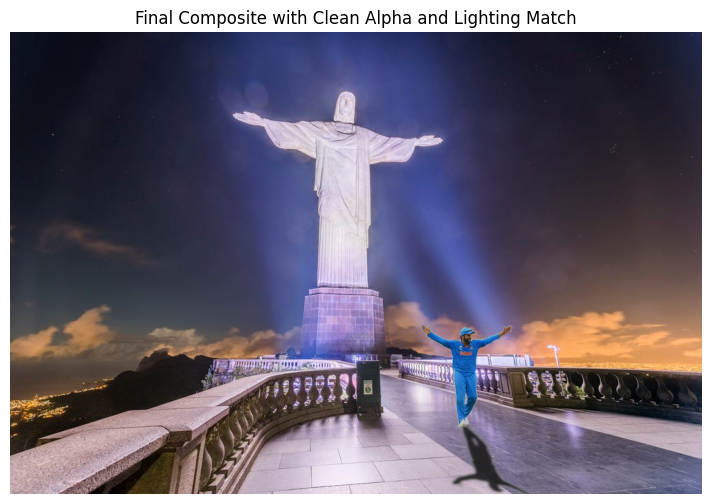

In [ ]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np


scene = Image.open("/content/scene.jpg").convert("RGBA")
person = Image.open("person_cutout.png").convert("RGBA")


scale_factor = 0.125
person = person.resize((int(person.width * scale_factor), int(person.height * scale_factor)), Image.Resampling.LANCZOS)
position = (585, 420)


person_rgb = person.convert("RGB")
person_alpha = person.getchannel("A")


enhancer = ImageEnhance.Color(person_rgb)
person_rgb = enhancer.enhance(1.1)


blue_overlay = Image.new("RGB", person_rgb.size, (30, 60, 120))
person_rgb = Image.blend(person_rgb, blue_overlay, alpha=0.1)

brightness = ImageEnhance.Brightness(person_rgb)
person_rgb = brightness.enhance(0.9)


alpha_np = np.array(person_alpha)
alpha_np[alpha_np < 20] = 0
clean_alpha = Image.fromarray(alpha_np.astype('uint8'))


person_adjusted = person_rgb.convert("RGBA")
person_adjusted.putalpha(clean_alpha)


final_lit = scene.copy()
final_lit.paste(shadow_img, shadow_pos, shadow_img)
final_lit.paste(person_adjusted, position, person_adjusted)


final_lit.save("final_composite_fixed_alpha.png")

plt.figure(figsize=(12, 6))
plt.imshow(final_lit)
plt.axis('off')
plt.title("Final Composite with Clean Alpha and Lighting Match")
plt.show()


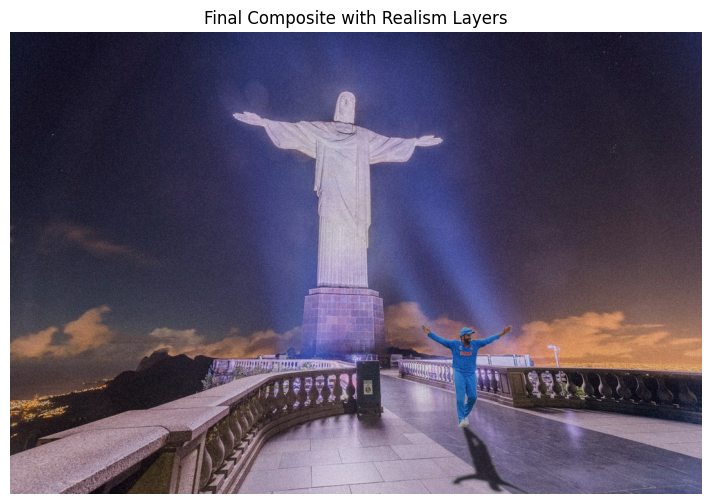

In [ ]:

overlay = Image.new("RGBA", final_lit.size, (40, 20, 80, 40))
final_lit = Image.alpha_composite(final_lit, overlay)

import cv2
import numpy as np


vignette = np.zeros((final_lit.height, final_lit.width), dtype=np.uint8)
cv2.circle(vignette, (final_lit.width//2, final_lit.height//2), int(final_lit.width*0.75), 255, -1)
vignette = cv2.GaussianBlur(vignette, (0, 0), sigmaX=200)

vignette_layer = np.dstack([vignette]*3 + [vignette])
final_np = np.array(final_lit)
final_vignette = (final_np.astype(np.float32) * (vignette_layer/255)).astype(np.uint8)
final_lit = Image.fromarray(final_vignette)

noise = np.random.normal(0, 5, (final_lit.height, final_lit.width)).astype(np.uint8)
grain = np.stack([noise]*3 + [np.full_like(noise, 12)], axis=2)
grain_layer = Image.fromarray(grain, mode="RGBA")
final_lit = Image.alpha_composite(final_lit, grain_layer)


plt.figure(figsize=(12, 6))
plt.imshow(final_lit)
plt.axis("off")
plt.title("Final Composite with Realism Layers")
plt.show()


In [ ]:
from PIL import ImageEnhance

brightness = ImageEnhance.Brightness(final_lit)
final_lit = brightness.enhance(1.2)


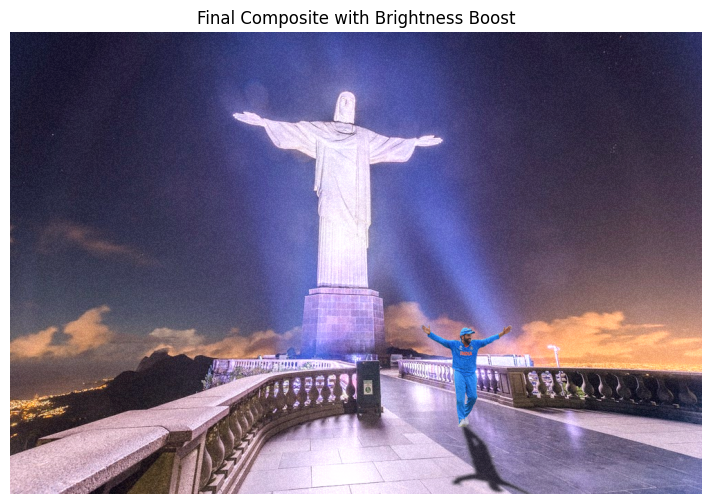

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.imshow(final_lit)
plt.axis("off")
plt.title("Final Composite with Brightness Boost")
plt.show()
